# Check dragon nodes on PANDA

In this notebook we will use the TFs that were found to have "differential" correlation between the CMS2 and CMS4
subtypes to interrogate the PANDA networks.

First we will define some common filenames and functions.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import os


In [2]:
def read_pandas(panda_fn):
    panda_data = {}
    for key, datafn in panda_fn.items():
        print(key)
        panda_data[key] = pd.read_csv(datafn, sep = ' ', index_col = 0)
    return(panda_data)

def read_dragons(dragon_fn):
    dragon_data = {}
    for key, datafn in dragon_fn.items():
        print(key)
        dragon_data[key] = pd.read_csv(datafn, sep = '\t', index_col = 0)
    return(dragon_data)

def get_indegree(panda_data, th = 0.5):
    df = pd.DataFrame()
    for key, datafn in panda_data.items():
        print(key)
        temp = pd.DataFrame((datafn*1*(datafn>th)).sum(axis = 0))
        temp = temp.rename(columns={0:key})
        df = df.merge(temp, left_index=True, right_index=True, how = 'outer').fillna(-1)
    return(df)
        
def get_outdegree(panda_data, th = 0.5):
    df = pd.DataFrame()
    for key, datafn in panda_data.items():
        print(key)
        temp = pd.DataFrame((datafn*1*(datafn>th)).sum(axis = 1))
        temp = temp.rename(columns={0:key})
        df = df.merge(temp, left_index=True, right_index=True, how = 'outer').fillna(-1)
    return(df)
        

Mapping of genes with the gencode names

In [3]:
v26_mapping = pd.read_csv('gen_v26_mapping.csv')
ens2sym = {v26_mapping['gene_id'].values[i].split('.')[0]:v26_mapping['gene_name'].values[i] for i in range(len(v26_mapping))}
sym2ens = {j:i for i,j in ens2sym.items()}

PANDA network definitions

In [4]:
panda_fn  = {#'cms1':'../results/batch-coad-subtype-20240510/tcga_coad_cms1/analysis/panda/panda_tcga_coad_cms1.txt',
             'cms2': '../results/batch-coad-subtype-20240510/tcga_coad_cms2/analysis/panda/panda_tcga_coad_cms2.txt',
             #'cms3': '../results/batch-coad-subtype-20240510/tcga_coad_cms3/analysis/panda/panda_tcga_coad_cms3.txt',
             'cms4': '../results/batch-coad-subtype-20240510/tcga_coad_cms4/analysis/panda/panda_tcga_coad_cms4.txt'}

Reading PANDAs

In [5]:
pandas = read_pandas(panda_fn)

cms2
cms4


In [6]:
# we need to keep track of the TF names for later, and we are going to check those that are common between CMS2 and CMS4
tf_pandas_shared = set(pandas['cms2'].index.tolist()).intersection(set(pandas['cms4'].index.tolist()))

We need the cluster names generated by the `colon_subtype_dragons` notebook. We provide them alongside the code. 

In [8]:
clusters = {'cluster_A':'dragon-post-paper/all_cms_dragon_clustA.csv',
            'cluster_D':'dragon-post-paper/all_cms_dragon_clustD.csv',}

Specify output folder: if the folder doesn't exist it is created

In [11]:
output_folder = 'dragon-post-paper/'
# make folder if it does not exist
if not os.path.exists(output_folder):
    os.makedirs(output_folder)
else:
    print('Folder exists')

Folder exists


In [41]:
# Specify which cluster we are going to use (either cluster A or D)
cluster_name = 'cluster_A'
# Files will be saved in a subfolder with the cluster name
output_folder = output_folder + cluster_name + '_panda/'
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

# Read the cluster file and get the TFs of interest
ca = pd.read_csv(clusters[cluster_name], index_col=0)
# The table keeps all edges from the TF of interest, then we have to subselect only the edges of interest
tf_ca = set(ca[ca['oi']==True]['node1_tf'].tolist() + ca[ca['oi']==True]['node2_tf'].tolist())
# These would be the TFs for which we have looked into the expression
tf_expression = set(ca[ca['oi']==True]['node2_tf'].tolist())


## If we want to use all tf of interest in the two clusters
#ca = pd.read_csv(clusters['cluster_A'], index_col=0)
#cd = pd.read_csv(clusters['cluster_D'], index_col=0)
#tf_ca = set(ca[ca['oi']==True]['node1_tf'].tolist() + ca[ca['oi']==True]['node2_tf'].tolist())
#tf_cd = set(cd[cd['oi']==True]['node1_tf'].tolist() + cd[cd['oi']==True]['node2_tf'].tolist())
# tf_ca = tf_ca.union(tf_cd)

## Check PANDA network for TFs of interest

We have extracted the TFs of interest for the cluster specified, now we check what targets of TFs have undergone the
biggest changes between the two subtypes

In [42]:
# get only edges for tf from dragon
cms2_dragon = pandas['cms2'].loc[list(set(tf_pandas_shared).intersection(tf_ca)),:].melt(ignore_index = False, var_name = 'ens', value_name = 'cms2').reset_index()
cms4_dragon = pandas['cms4'].loc[list(set(tf_pandas_shared).intersection(tf_ca)),:].melt(ignore_index = False, var_name = 'ens', value_name = 'cms4').reset_index()

# Get long table for values
values_cms = cms2_dragon.merge(cms4_dragon, on = ['tf', 'ens'], how = 'inner')

values_cms 

,tf,ens,cms2,cms4
0,DUXA,ENSG00000000003,0.682195,0.209324
1,HOXA3,ENSG00000000003,1.176464,0.451517
2,LCORL,ENSG00000000003,0.687268,0.192688
3,MESP1,ENSG00000000003,-1.064699,-0.987239
4,NFE2L3,ENSG00000000003,0.161999,-0.095953
...,...,...,...,...
451922,FOXJ2,ENSG00000284594,-2.671895,-2.758793
451923,MEOX2,ENSG00000284594,-1.866843,-1.943383
451924,GATA6,ENSG00000284594,-1.069402,-1.163465
451925,RFX2,ENSG00000284594,0.305804,0.364878


In [43]:
# Get difference between the actual PANDA edge values
values_cms['value_cms2_cms4'] = values_cms['cms2'] - values_cms['cms4']
values_cms['value_cms2_cms4_abs'] = np.abs(values_cms['value_cms2_cms4'])
values_cms.head()

,tf,ens,cms2,cms4,value_cms2_cms4,value_cms2_cms4_abs
0,DUXA,ENSG00000000003,0.682195,0.209324,0.472872,0.472872
1,HOXA3,ENSG00000000003,1.176464,0.451517,0.724947,0.724947
2,LCORL,ENSG00000000003,0.687268,0.192688,0.494580,0.494580
3,MESP1,ENSG00000000003,-1.064699,-0.987239,-0.077460,0.077460
4,NFE2L3,ENSG00000000003,0.161999,-0.095953,0.257952,0.257952


In [44]:
# Get long table for ranks (for each tf rank the genes)
# We do the same as before but we compare ranks, instead of actual values
rank_cms2 = pandas['cms2'].loc[list(set(tf_pandas_shared).intersection(tf_ca)),:].rank(axis = 1).melt(ignore_index = False, var_name = 'ens', value_name = 'rank_cms2').reset_index()
rank_cms4 = pandas['cms4'].loc[list(set(tf_pandas_shared).intersection(tf_ca)),:].rank(axis = 1).melt(ignore_index = False, var_name = 'ens', value_name = 'rank_cms4').reset_index()
rank_cms = rank_cms2.merge(rank_cms4, on = ['tf', 'ens'], how = 'inner')
rank_cms['rank_cms2_cms4'] = rank_cms['rank_cms2'] - rank_cms['rank_cms4']
rank_cms['rank_cms2_cms4_abs'] = np.abs(rank_cms['rank_cms2_cms4'])
rank_cms.head()

,tf,ens,rank_cms2,rank_cms4,rank_cms2_cms4,rank_cms2_cms4_abs
0,DUXA,ENSG00000000003,14758.0,11590.0,3168.0,3168.0
1,HOXA3,ENSG00000000003,12891.0,10572.0,2319.0,2319.0
2,LCORL,ENSG00000000003,13168.0,10864.0,2304.0,2304.0
3,MESP1,ENSG00000000003,922.0,2723.0,-1801.0,1801.0
4,NFE2L3,ENSG00000000003,14134.0,11494.0,2640.0,2640.0


In [45]:
# merge the two tables
panda_rank = rank_cms.merge(values_cms, on = ['tf', 'ens'])
panda_rank['symbol'] = panda_rank['ens'].map(ens2sym)
panda_rank.sort_values('value_cms2_cms4_abs', ascending = False)

,tf,ens,rank_cms2,rank_cms4,rank_cms2_cms4,rank_cms2_cms4_abs,cms2,cms4,value_cms2_cms4,value_cms2_cms4_abs,symbol
340838,HOXA3,ENSG00000225315,14314.0,4166.0,10148.0,10148.0,1.534973,-2.546409,4.081382e+00,4.081382e+00,RP11-293P20.2
340844,POU2F3,ENSG00000225315,19583.0,15004.0,4579.0,4579.0,5.268483,1.481077,3.787406e+00,3.787406e+00,RP11-293P20.2
448386,HOXA3,ENSG00000281383,3581.0,12562.0,-8981.0,8981.0,-2.667444,1.041533,-3.708977e+00,3.708977e+00,CH507-513H4.5
340855,FOXJ2,ENSG00000225315,12734.0,3995.0,8739.0,8739.0,1.302393,-2.345242,3.647634e+00,3.647634e+00,RP11-293P20.2
340850,FOXJ1,ENSG00000225315,18968.0,11955.0,7013.0,7013.0,4.651830,1.029829,3.622002e+00,3.622002e+00,RP11-293P20.2
...,...,...,...,...,...,...,...,...,...,...,...
329511,FOXJ1,ENSG00000214558,11973.0,12407.0,-434.0,434.0,1.131113,1.131110,2.445627e-06,2.445627e-06,RP11-74E24.2
26328,YY2,ENSG00000074706,348.0,322.0,26.0,26.0,-1.385259,-1.385258,-1.623747e-06,1.623747e-06,IPCEF1
11062,FOXA1,ENSG00000037280,5617.0,5524.0,93.0,93.0,-1.945295,-1.945294,-1.435298e-06,1.435298e-06,FLT4
325950,PROX2,ENSG00000213707,6533.0,6687.0,-154.0,154.0,-0.886755,-0.886754,-9.347164e-07,9.347164e-07,HMGB1P10


##### Select targets that vary a lot in value and in rank

For each TF, we have edges towards all targets. We are interested in finding the targets of the tfs of interest that
change "probability" of connection a lot between CMS2 and CMS4.
1. We assume that a gene is a TF target in that PANDA
network if its edge has value > 1, ence we select only edges that have values larger than 1 in either CMS2 or CMS4.
2. Out of these targets, we select those for which the ranking between CMS2 and CMS4 is high (we'll check below the
   percentile thresholds)
3. We also select the targets for which there is a difference of at least 1 between CMS2 and CMS4

/home/ubuntu/miniconda3/envs/nb/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


967.0 1922.0


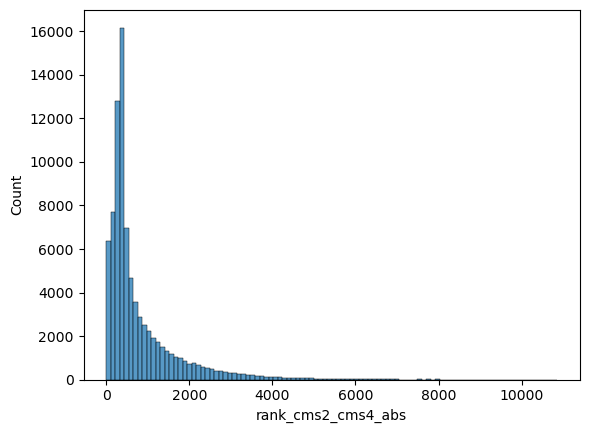

In [46]:
temp0 = panda_rank[((panda_rank['cms2']>1) | (panda_rank['cms4']>1))]
#sns.histplot(temp0['value_cms2_cms4_abs'], bins = 100)
sns.histplot(temp0['rank_cms2_cms4_abs'], bins = 100)
print(np.percentile(temp0['rank_cms2_cms4_abs'], 75), np.percentile(temp0['rank_cms2_cms4_abs'], 90))

Around 1000 is the 75th percentile for the differences between two edges, while around 2000 is the 90th percentile.   
That is less than 25% of edges change their rank of more than 1000 positions, in either directions

Now we are gonna get edges that: 
- Have a difference in ranking of more than 1000 (or 2000)
- Are weighted at least 1 in either cms2 or cms4 (we ignore changes of edges that are not really plausible)
- Have a difference in absolute value between cms2 and cms4 of more than 1

In [47]:
th = 1000
temp = panda_rank[(panda_rank['value_cms2_cms4_abs']>1) & (panda_rank['rank_cms2_cms4_abs']>th) & ((panda_rank['cms2']>1) | (panda_rank['cms4']>1))].sort_values('rank_cms2_cms4_abs', ascending = False)
temp

,tf,ens,rank_cms2,rank_cms4,rank_cms2_cms4,rank_cms2_cms4_abs,cms2,cms4,value_cms2_cms4,value_cms2_cms4_abs,symbol
340856,MEOX2,ENSG00000225315,14215.0,3360.0,10855.0,10855.0,1.103369,-2.288557,3.391926,3.391926,RP11-293P20.2
340838,HOXA3,ENSG00000225315,14314.0,4166.0,10148.0,10148.0,1.534973,-2.546409,4.081382,4.081382,RP11-293P20.2
340859,FOXA1,ENSG00000225315,14044.0,3986.0,10058.0,10058.0,1.159921,-2.228002,3.387923,3.387923,RP11-293P20.2
447990,MEOX2,ENSG00000280832,6040.0,15291.0,-9251.0,9251.0,-1.775200,1.252996,-3.028197,3.028197,ST3GAL4-AS1
448392,POU2F3,ENSG00000281383,4294.0,13484.0,-9190.0,9190.0,-2.282616,1.172703,-3.455319,3.455319,CH507-513H4.5
...,...,...,...,...,...,...,...,...,...,...,...
248085,POU2F3,ENSG00000172965,17571.0,18579.0,-1008.0,1008.0,3.121456,4.306172,-1.184716,1.184716,MIR4435-2HG
249482,HOXA3,ENSG00000173372,17079.0,18083.0,-1004.0,1004.0,2.857403,4.062901,-1.205498,1.205498,C1QA
37244,POU2F3,ENSG00000089199,18361.0,17358.0,1003.0,1003.0,4.380840,2.002611,2.378229,2.378229,CHGB
235291,HOXA3,ENSG00000169375,17647.0,16646.0,1001.0,1001.0,3.992427,2.008392,1.984035,1.984035,SIN3A


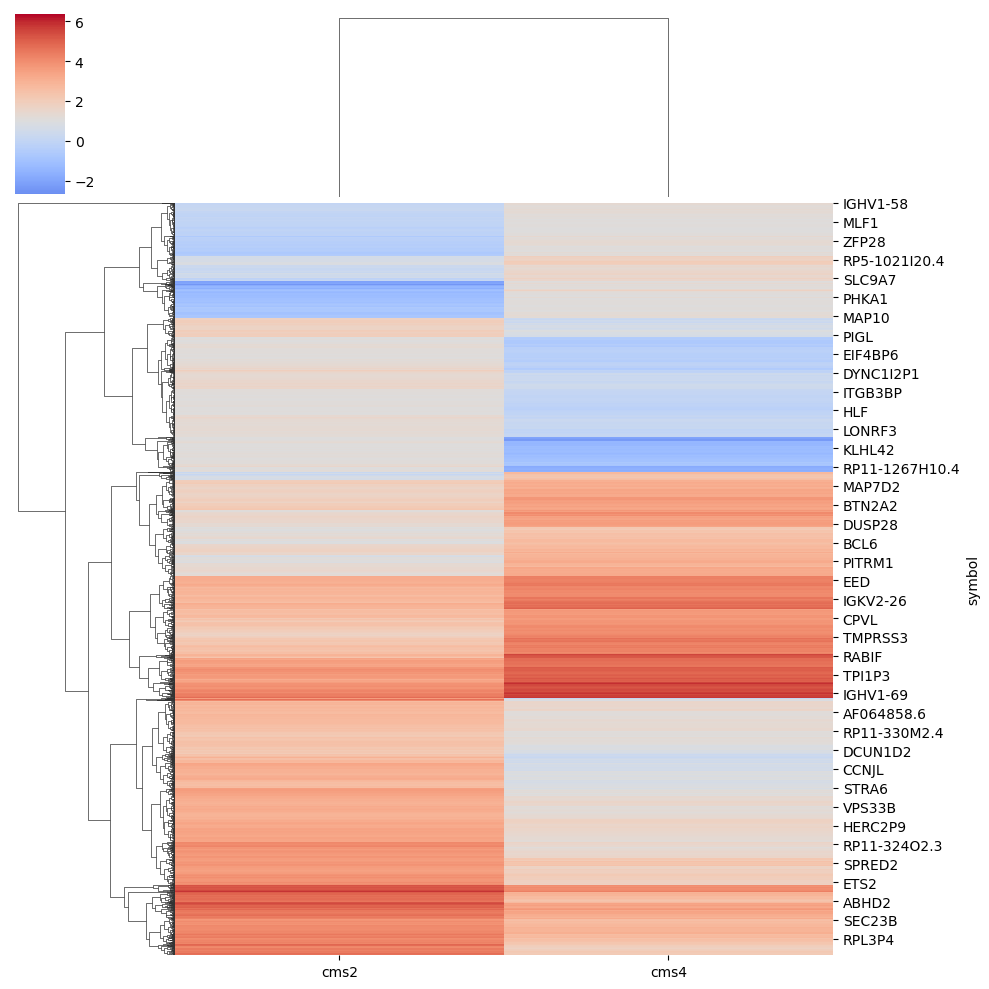

In [48]:
# edges with high rank difference
sns.clustermap(temp.loc[:,['symbol','cms2','cms4']].set_index('symbol'), cmap = 'coolwarm', center = 1)

### Check what pathways these genes are involved with

In [49]:
# pathway analysis of the genes involved , background is all the genes in the pandas
import gseapy as gp
gene_list = temp.symbol.unique().tolist()
print(len(gene_list))
bckg = panda_rank.symbol.unique().tolist()
res_reactome = gp.enrich(gene_list = gene_list, gene_sets='/home/ubuntu/tcga-coad-subtype/notebook/reactome_slim/hugo_reactome_slim.gmt', background = bckg)


1326


In [50]:
res_reactome.results.sort_values('Adjusted P-value').to_csv(output_folder + 'reactome_enrichment.csv')

In [51]:
res_reactome.results.sort_values('Adjusted P-value')[res_reactome.results['Adjusted P-value']<0.05]

/tmp/ipykernel_1948/1814681701.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  res_reactome.results.sort_values('Adjusted P-value')[res_reactome.results['Adjusted P-value']<0.05]


,Gene_set,Term,Overlap,P-value,Adjusted P-value,Odds Ratio,Combined Score,Genes
254,hugo_reactome_slim.gmt,Leishmania phagocytosis,26/129,4.215699e-07,0.000236,3.582868,52.593917,IGHV1-69;DOCK1;ELMO2;IGHV3-7;WIPF2;RAC1;CD247;...
61,hugo_reactome_slim.gmt,Cell surface interactions at the vascular wall,30/182,4.831811e-06,0.000825,2.799769,34.269977,CAV1;ITGAM;IGHV1-69;CEACAM3;TNFRSF10A;IGHV3-7;...
163,hugo_reactome_slim.gmt,Fcgamma receptor (FCGR) dependent phagocytosis,27/156,5.595846e-06,0.000825,2.969623,35.913094,NF2;IGHV1-69;DOCK1;ELMO2;IGHV3-7;WIPF2;RAC1;CD...
84,hugo_reactome_slim.gmt,Creation of C4 and C2 activators,18/81,5.896201e-06,0.000825,4.060817,48.897116,IGKV4-1;IGLV3-25;IGKV1D-39;IGKV2D-30;IGLV3-27;...
81,hugo_reactome_slim.gmt,Complement cascade,21/110,1.289219e-05,0.001272,3.351260,37.731464,IGHV1-69;CD19;IGHV3-7;C4BPB;IGLV3-16;IGKV1D-39...
42,hugo_reactome_slim.gmt,Binding and Uptake of Ligands by Scavenger Rec...,20/102,1.362442e-05,0.001272,3.465189,38.822756,IGHV1-69;APOL1;IGHV3-7;IGLV3-16;IGKV1D-39;COL4...
218,hugo_reactome_slim.gmt,Initial triggering of complement,18/89,2.337344e-05,0.001870,3.604878,38.442093,IGKV4-1;IGLV3-25;IGKV1D-39;IGKV2D-30;IGLV3-27;...
24,hugo_reactome_slim.gmt,Anti-inflammatory response favouring Leishmani...,22/137,1.270912e-04,0.008896,2.715849,24.362807,CALM1;IGHV1-69;PLK2;IGHV3-7;CD247;IGLV3-16;IGK...
481,hugo_reactome_slim.gmt,Signaling by the B Cell Receptor (BCR),25/167,1.456561e-04,0.009063,2.496807,22.057450,CALM1;IGHV1-69;CD19;PSMD13;CD22;PSME2;IGHV3-7;...


In [52]:
res = gp.enrich(gene_list = gene_list, gene_sets=['KEGG_2021_Human'], background = bckg)
res.results.sort_values('Adjusted P-value').to_csv(output_folder + 'kegg_enrichment.csv')

In [53]:
res.results.sort_values(by = 'Adjusted P-value').head(15)

,Gene_set,Term,P-value,Adjusted P-value,Old P-value,Old adjusted P-value,Odds Ratio,Combined Score,Genes
0,KEGG_2021_Human,Pathways in cancer,0.000748,0.142307,0,0,1.711453,12.319363,CDKN1A;CSF3R;WNT2B;HDAC1;MGST3;LEF1;TGFA;CSF2R...
1,KEGG_2021_Human,Transcriptional misregulation in cancer,0.000978,0.142307,0,0,2.302797,15.958257,CDKN1A;ITGAM;BCL11B;DEFA6;GADD45A;HDAC1;MMP3;P...
2,KEGG_2021_Human,Gastric cancer,0.003165,0.250779,0,0,2.272353,13.078603,CDKN1A;ABCB1;SHC3;SMAD3;WNT2B;GADD45A;TGFB3;RE...
7,KEGG_2021_Human,Intestinal immune network for IgA production,0.009354,0.250779,0,0,3.343808,15.622127,PIGR;IL15RA;HLA-DMA;CXCL12;TNFRSF17;HLA-DOA;HL...
4,KEGG_2021_Human,Hippo signaling pathway,0.005438,0.250779,0,0,2.084977,10.871736,SMAD3;WNT2B;TGFB3;LEF1;AXIN2;LIMD1;AMOT;TGFBR2...
5,KEGG_2021_Human,Hepatocellular carcinoma,0.005589,0.250779,0,0,2.031952,10.539595,NQO1;CDKN1A;SHC3;SMAD3;WNT2B;GADD45A;TGFB3;MGS...
6,KEGG_2021_Human,Basal cell carcinoma,0.007512,0.250779,0,0,2.901626,14.192776,BMP4;CDKN1A;BMP2;WNT2B;GADD45A;PTCH1;LEF1;CTNN...
3,KEGG_2021_Human,Cytokine-cytokine receptor interaction,0.004161,0.250779,0,0,1.940175,10.636244,IL15RA;CCL24;CSF3;CCL11;CSF3R;TGFB3;IFNGR2;TNF...
15,KEGG_2021_Human,PPAR signaling pathway,0.015162,0.250779,0,0,2.545488,10.662974,CPT2;MMP1;ME1;ACSL6;ACSL5;LPL;HMGCS2;SLC27A2;P...
14,KEGG_2021_Human,Endometrial cancer,0.013600,0.250779,0,0,2.598662,11.168201,CDKN1A;CDH1;GADD45A;MYC;LEF1;CTNNA1;CTNNB1;AXI...


In [60]:
# We check what happens for the top KEGG pathways:
# For Cluster D
# - transcriptional misregulation in cancer
# - TGF-beta signaling pathway

# For Cluster A (adjuster pvalues are not really significant, but we can check the top ones)
# - Pathways in cancer
# Transcriptional misregulation of cancer
pathway = 'Intestinal immune network for IgA production'
pathway_prefix = '_'.join(pathway.split(' '))
genes_oi = res.results.sort_values(by = 'Adjusted P-value').iloc[0,:].Genes.split(';')

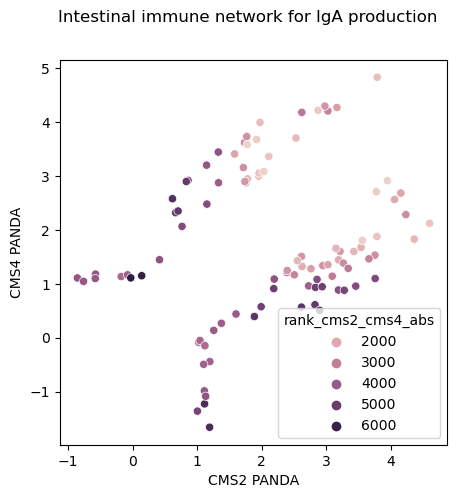

In [61]:
# Plot relatiionship between PANDA cms2 and cms4 values
f,ax = plt.subplots(1,figsize = (5,5))
sns.scatterplot(x = 'cms2', y = 'cms4', data = temp[temp.symbol.isin(genes_oi)], hue = 'rank_cms2_cms4_abs')
f.suptitle(pathway)
ax.set_xlabel('CMS2 PANDA')
ax.set_ylabel('CMS4 PANDA')
f.savefig(output_folder+pathway_prefix+'.pdf')


### Plot actual PANDA values of targets of interest

In [62]:
# cms2 values
aaa = pd.pivot_table(temp[temp.symbol.isin(genes_oi)], columns = 'symbol', index = 'tf', values = 'cms2')
# cms4 values
bbb = pd.pivot_table(temp[temp.symbol.isin(genes_oi)], columns = 'symbol', index = 'tf', values = 'cms4')

In [63]:
temp[temp.symbol.isin(genes_oi)]
temp.head()

,tf,ens,rank_cms2,rank_cms4,rank_cms2_cms4,rank_cms2_cms4_abs,cms2,cms4,value_cms2_cms4,value_cms2_cms4_abs,symbol,edge
194212,DUXA,ENSG00000158315,18892.0,19974.0,-1082.0,1082.0,3.745148,4.848225,-1.103078,1.103078,RHBDL2,DUXA-RHBDL2
44781,DUXA,ENSG00000100170,18943.0,20083.0,-1140.0,1140.0,3.890563,4.957977,-1.067414,1.067414,SLC5A1,DUXA-SLC5A1
19688,DUXA,ENSG00000065923,18914.0,19957.0,-1043.0,1043.0,3.795290,4.838077,-1.042787,1.042787,SLC9A7,DUXA-SLC9A7
406363,FOXA1,ENSG00000259053,18468.0,20320.0,-1852.0,1852.0,4.331033,5.618168,-1.287135,1.287135,RP11-33N16.3,FOXA1-RP11-33N16.3
107202,FOXA1,ENSG00000123843,17536.0,18633.0,-1097.0,1097.0,2.825935,4.097811,-1.271877,1.271877,C4BPB,FOXA1-C4BPB


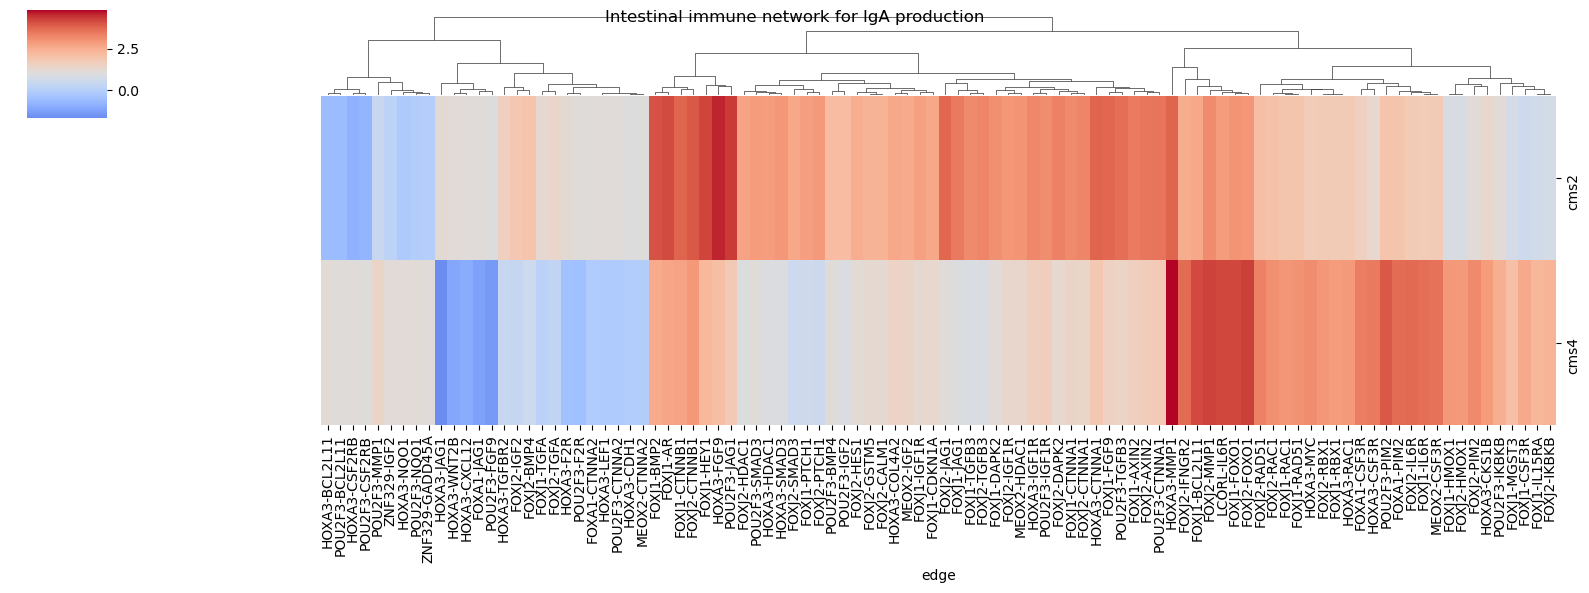

In [64]:
temp['edge'] = temp['tf'] + '-' + temp['symbol']
temp = temp.sort_values(by = 'tf')
g1 = sns.clustermap((temp[temp.symbol.isin(genes_oi)].loc[:,['edge','cms2','cms4']]).set_index('edge').T, cmap = 'coolwarm', center = 1, 
               xticklabels = True, 
               row_cluster=False,
               figsize = (16,6))
g1.fig.suptitle(pathway)
g1.fig.savefig(output_folder+pathway_prefix+'.pdf')